# DeepONet for learning the derivative operator

Notation:
* $u$: input function
* $v$: output function
* $x$: location where we want to evaluate the output function
* $b_i$: branch net outputs (from the input function $u$)
* $t_i$: trunk net outputs (from the location $x$)

## Setup + training data
We learn the operator $\mathcal{G}: u \mapsto v$ where $v(x) = \frac{d}{dx}u(x)$ for functions on $[0,1]$.

**Good training data** for a derivative operator is anything where $u$ and $u'$ are easy to compute. We’ll use a simple trigonometric family with analytic derivatives:
$$u(x)=a_0+\sum_{k=1}^{K} \big(a_k\sin(\pi kx)+b_k\cos(\pi kx)\big).$$
Then the output is analytic term-by-term:
$$v(x)=u'(x)=\sum_{k=1}^{K} (\pi k)\,a_k\cos(\pi kx)-(\pi k)\,b_k\sin(\pi kx).$$

We will:
1. Sample a random trig series $u$ (this is one “function example”).
2. Observe $u$ at **10 sensor points** $\{x_j\}$ to form the DeepONet input.
3. Train a DeepONet to output $v(x)$ for query locations $x$ in $[0,1]$.

In [ ]:
# Shared operator-family hyperparameters (single source of truth)
K = 6
# Using decay_power = 0 gives equal weighting to all Fourier modes, which can lead to overfitting high-frequency noise in the training data. Using decay_power = 2 gives more weight to low-frequency modes, which can improve generalization and stability of the learned operator.
decay_power = 2.0

In [13]:
# Imports + global config
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Reproducibility
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# Plot style (simple + lecture-friendly)
plt.rcParams.update({"figure.figsize": (7, 4), "axes.grid": True})

device: cpu


In [14]:
# Random trig-series generator with analytic derivative on [0,1]
# We use ONLY sin(πkx), cos(πkx) modes. This avoids enforcing 1-periodicity on [0,1],
# while still containing the usual 2π modes (they appear when k is even).

def sample_pi_coeffs(
    K: int,
    *,
    scale: float = 1.0,
    const_scale: float = 0.5,
    decay_power: float = 1.0,
 ):
    """Sample coefficients for u(x)=a0+sum_{k=1..K} a_k sin(πkx)+b_k cos(πkx).

    We bias toward smoother functions by shrinking higher-frequency coefficients like 1/k^decay_power.
    """
    k = np.arange(1, K + 1, dtype=float)
    decay = 1.0 / (k ** decay_power)
    a0 = const_scale * np.random.randn()
    a = scale * decay * np.random.randn(K)
    b = scale * decay * np.random.randn(K)
    return a0, a, b

def u_and_v_pi(x: np.ndarray, a0: float, a: np.ndarray, b: np.ndarray):
    """Return u(x) and v(x)=u'(x) for x shape (n,)."""
    x = x.reshape(-1)
    K = len(a)
    u = a0 * np.ones_like(x)
    v = np.zeros_like(x)
    for k in range(1, K + 1):
        w = np.pi * k
        u = u + a[k - 1] * np.sin(w * x) + b[k - 1] * np.cos(w * x)
        v = v + a[k - 1] * w * np.cos(w * x) - b[k - 1] * w * np.sin(w * x)
    return u, v

# 10 sensor locations for the branch input
# These functions are not assumed periodic, so using both endpoints is fine.
m_sensors = 10
x_sensors = np.linspace(0.0, 1.0, m_sensors)
print("x_sensors:", np.round(x_sensors, 3))

x_sensors: [0.    0.111 0.222 0.333 0.444 0.556 0.667 0.778 0.889 1.   ]


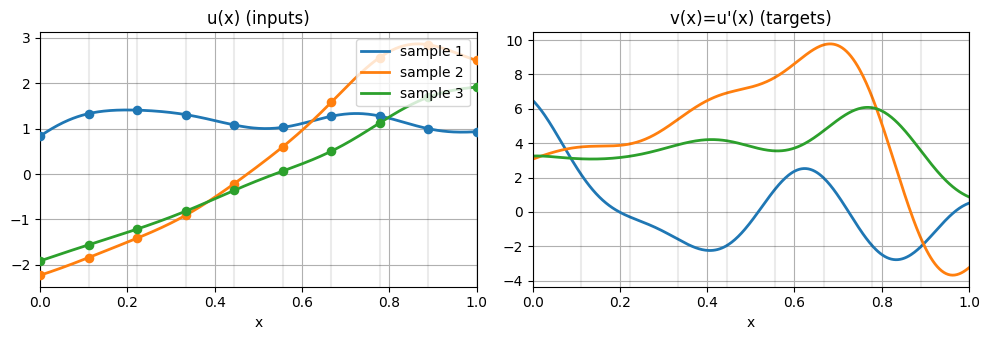

In [15]:
# Visualize a few random training functions and their outputs
n_show = 3         # how many random functions to plot
x_plot = np.linspace(0.0, 1.0, 400)

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharex=True)
for i in range(n_show):
    a0, a, b = sample_pi_coeffs(K, scale=1.0, const_scale=0.5, decay_power=decay_power)
    u, v = u_and_v_pi(x_plot, a0, a, b)
    u_sensors, _ = u_and_v_pi(x_sensors, a0, a, b)
    line = axes[0].plot(x_plot, u, lw=2, label=f"sample {i+1}")[0]
    axes[0].scatter(x_sensors, u_sensors, s=35, color=line.get_color(), zorder=3)
    axes[1].plot(x_plot, v, lw=2, label=f"sample {i+1}")

# sensor locations as vertical markers
for ax in axes:
    for xs in x_sensors:
        ax.axvline(xs, color="k", alpha=0.08)
    ax.set_xlim(0, 1)
axes[0].set_title("u(x) (inputs)")
axes[1].set_title("v(x)=u'(x) (targets)")
axes[0].set_xlabel("x")
axes[1].set_xlabel("x")
axes[0].legend(loc="upper right")
plt.tight_layout()

## Build a training set (function samples + query points)
We generate many random input functions $u$; for each one we:
- sample it at the **10 sensors** $x_j$ to get the branch input $[u(x_1),\dots,u(x_{10})]$
- sample output targets $v(x)=u'(x)$ at random query points $x$ for the trunk input.

This produces supervised triples $(\,u\text{ at sensors},\ x,\ v(x)\,)$.

In [16]:
# Create training/validation datasets
N_train_funcs = 512    # number of random functions for training (kept modest for fast demos)
N_val_funcs = 128
Q_per_func = 32        # query points per function (each gives one supervised example)

def make_dataset(N_funcs: int, Q: int, K: int, *, decay_power: float):
    Xb_list, Xt_list, v_list = [], [], []
    for _ in range(N_funcs):
        a0, a, b = sample_pi_coeffs(K, scale=1.0, const_scale=0.5, decay_power=decay_power)
        u_sensors, _ = u_and_v_pi(x_sensors, a0, a, b)  # branch input
        # query points for trunk input
        xq = np.random.rand(Q)  # uniform on [0,1]
        _, vq = u_and_v_pi(xq, a0, a, b)
        # repeat sensor vector for each query point
        Xb_list.append(np.repeat(u_sensors.reshape(1, -1), Q, axis=0))
        Xt_list.append(xq.reshape(-1, 1))
        v_list.append(vq.reshape(-1, 1))
    Xb = np.concatenate(Xb_list, axis=0)
    Xt = np.concatenate(Xt_list, axis=0)
    v = np.concatenate(v_list, axis=0)
    return (torch.tensor(Xb, dtype=torch.float32),
            torch.tensor(Xt, dtype=torch.float32),
            torch.tensor(v, dtype=torch.float32))

Xb_train, Xt_train, v_train = make_dataset(N_train_funcs, Q_per_func, K, decay_power=decay_power)
Xb_val, Xt_val, v_val = make_dataset(N_val_funcs, Q_per_func, K, decay_power=decay_power)

print("train examples:", Xb_train.shape[0], "| branch dim:", Xb_train.shape[1], "| trunk dim:", Xt_train.shape[1])
print("val examples:", Xb_val.shape[0])

batch_size = 512
train_loader = DataLoader(TensorDataset(Xb_train, Xt_train, v_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(Xb_val, Xt_val, v_val), batch_size=batch_size, shuffle=False)

train examples: 16384 | branch dim: 10 | trunk dim: 1
val examples: 4096


## DeepONet model
We use a classic DeepONet factorization with $p=10$ latent terms:
- **Branch net**: maps sensor samples $[u(x_1),\dots,u(x_{10})] \mapsto b \in \mathbb{R}^p$
- **Trunk net**: maps query location $x \mapsto t(x) \in \mathbb{R}^p$
- Output: $\hat{v}(x) = \sum_{i=1}^p b_i\,t_i(x)$

In [17]:
# Define a small DeepONet
class MLP(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, width: int = 64, depth: int = 2):
        super().__init__()
        layers = []
        d = in_dim
        for _ in range(depth):
            layers += [nn.Linear(d, width), nn.Tanh()]
            d = width
        layers += [nn.Linear(d, out_dim)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class DeepONet(nn.Module):
    def __init__(self, m_sensors: int, p: int):
        super().__init__()
        self.branch = MLP(m_sensors, p, width=64, depth=2)
        self.trunk = MLP(1, p, width=64, depth=2)
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, u_sensors, x_query):
        b = self.branch(u_sensors)           # (batch, p)
        t = self.trunk(x_query)              # (batch, p)
        return (b * t).sum(dim=-1, keepdim=True) + self.bias

p_latent = 10
model = DeepONet(m_sensors=m_sensors, p=p_latent).to(device)
print(model)

DeepONet(
  (branch): MLP(
    (net): Sequential(
      (0): Linear(in_features=10, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
      (4): Linear(in_features=64, out_features=10, bias=True)
    )
  )
  (trunk): MLP(
    (net): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
      (4): Linear(in_features=64, out_features=10, bias=True)
    )
  )
)


In [18]:
# Train
epochs = 800
lr = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

def run_epoch(loader, train: bool):
    if train:
        model.train()
    else:
        model.eval()
    total_loss = 0.0
    n = 0
    for Xb, Xt, v in loader:
        Xb = Xb.to(device)
        Xt = Xt.to(device)
        v = v.to(device)
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            v_hat = model(Xb, Xt)
            loss = loss_fn(v_hat, v)
            if train:
                loss.backward()
                optimizer.step()
        total_loss += loss.item() * Xb.shape[0]
        n += Xb.shape[0]
    return total_loss / n

train_hist, val_hist = [], []
for ep in range(1, epochs + 1):
    tr = run_epoch(train_loader, train=True)
    va = run_epoch(val_loader, train=False)
    train_hist.append(tr)
    val_hist.append(va)
    if ep % 100 == 0 or ep == 1:
        print(f"epoch {ep:4d} | train {tr:.3e} | val {va:.3e}")

epoch    1 | train 1.000e+01 | val 6.652e+00
epoch  100 | train 6.768e-01 | val 6.923e-01
epoch  200 | train 2.710e-01 | val 2.700e-01
epoch  300 | train 7.975e-02 | val 9.366e-02
epoch  400 | train 6.604e-02 | val 7.766e-02
epoch  500 | train 1.140e-02 | val 1.336e-02
epoch  600 | train 1.250e-02 | val 1.736e-02
epoch  700 | train 1.122e-02 | val 1.166e-02
epoch  800 | train 1.081e-02 | val 1.197e-02


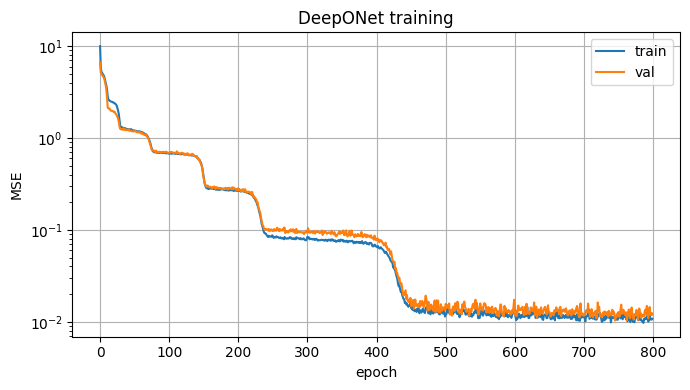

In [19]:
# Plot loss curves
plt.figure(figsize=(7, 4))
plt.semilogy(train_hist, label="train")
plt.semilogy(val_hist, label="val")
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.title("DeepONet training")
plt.legend()
plt.tight_layout()

## Try it on simple test functions
We’ll feed the network sensor samples of $u$ for a test function, then ask for predictions of $v(x)=u'(x)$ across a fine grid.

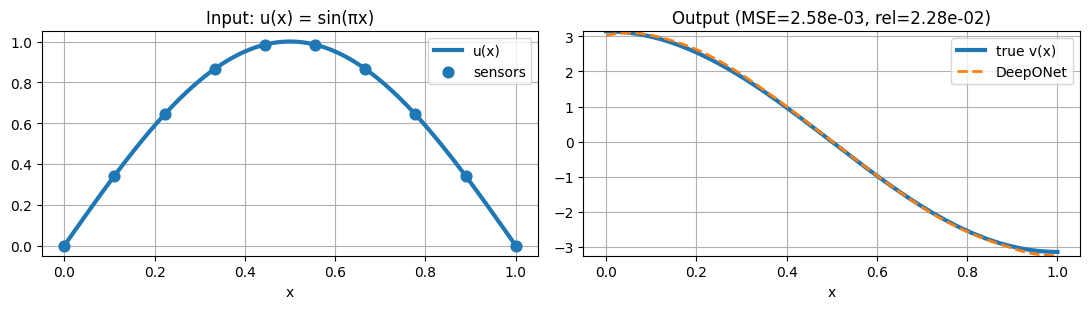

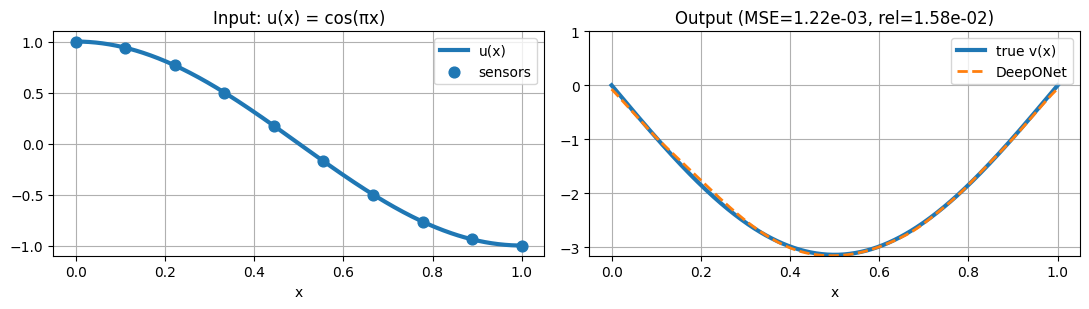

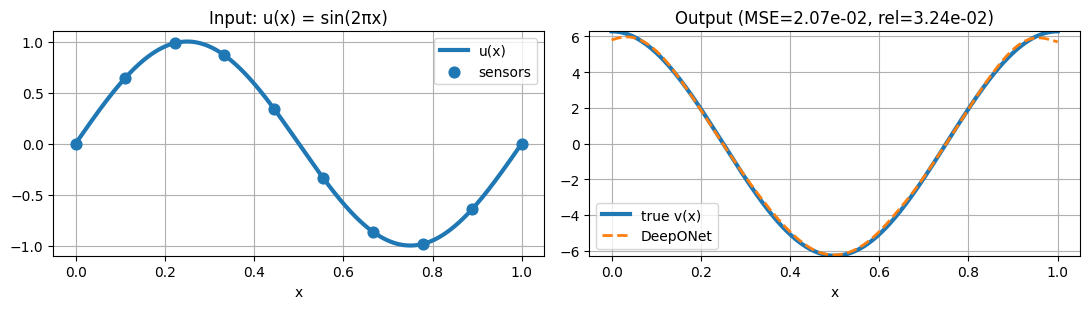

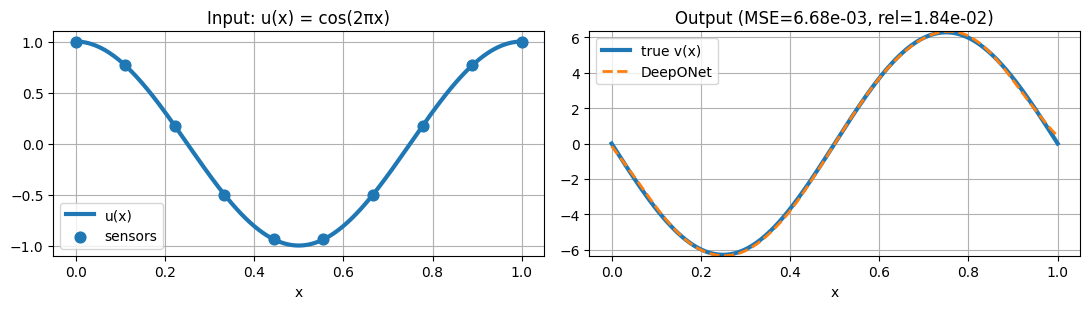

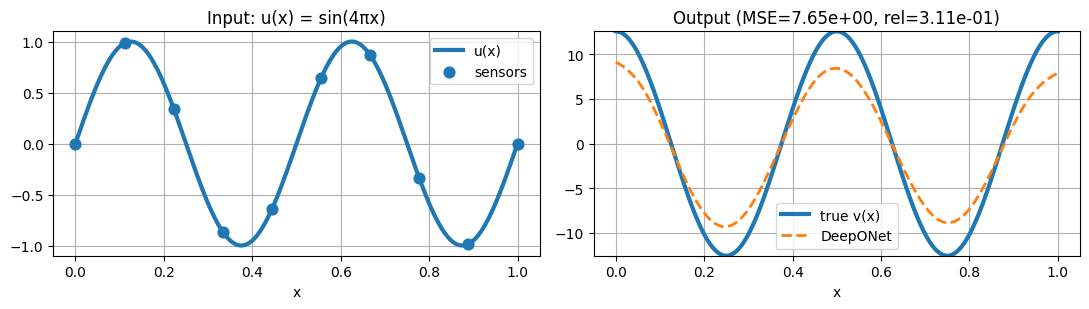

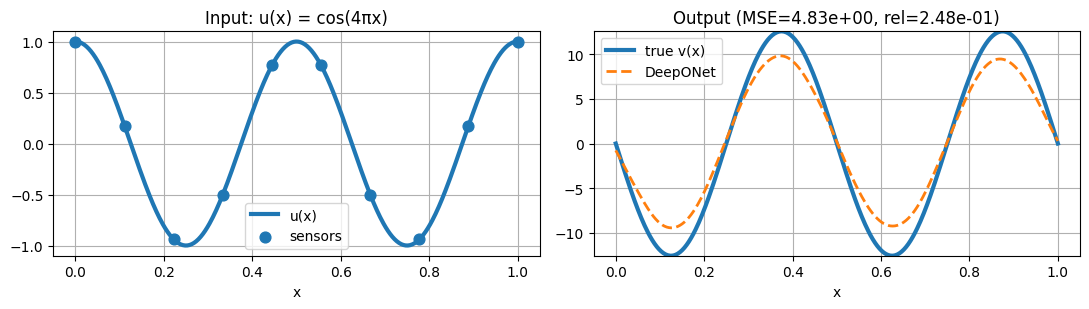

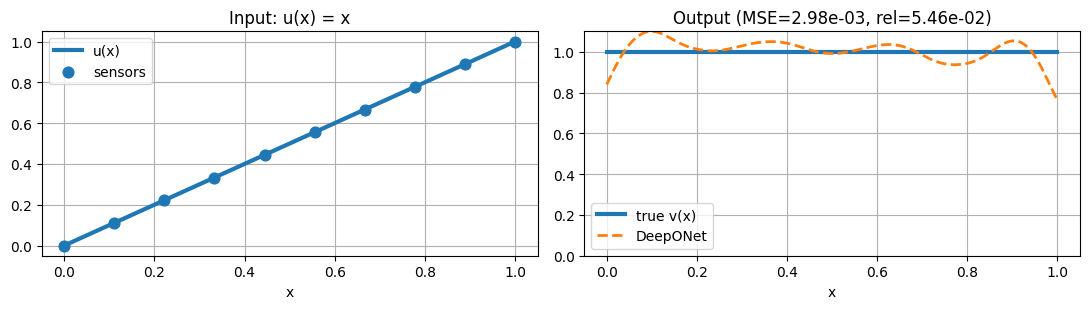

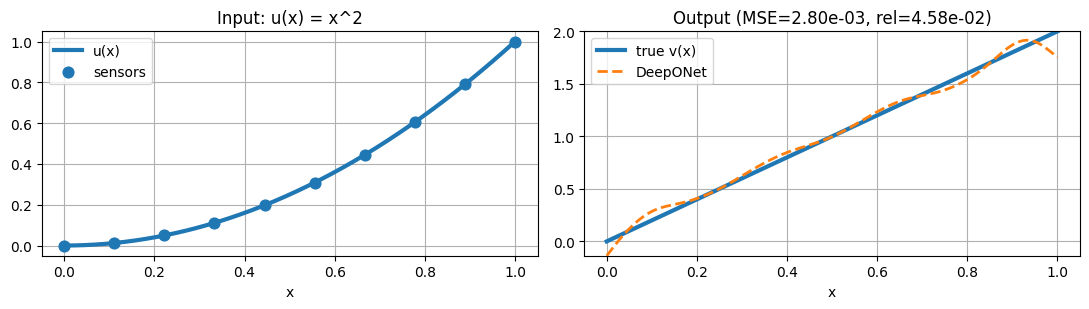

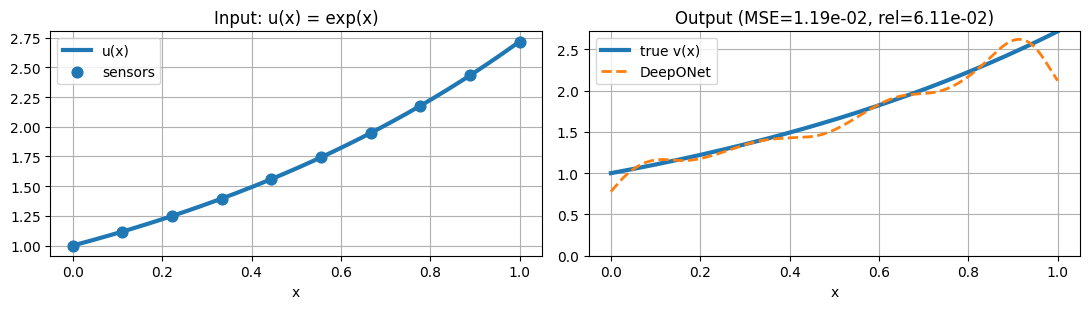

In [20]:
# Helpers for evaluating the trained operator on a single function
@torch.no_grad()
def predict_output_for_function(u_func, v_func, x_grid: np.ndarray):
    """
    u_func, v_func: callables with numpy input x -> numpy output
    x_grid: (n,) numpy array on [0,1]
    """
    u_s = u_func(x_sensors).astype(np.float32)
    Xb = torch.tensor(u_s.reshape(1, -1), dtype=torch.float32).repeat(len(x_grid), 1).to(device)
    Xt = torch.tensor(x_grid.reshape(-1, 1), dtype=torch.float32).to(device)
    v_hat = model(Xb, Xt).cpu().numpy().reshape(-1)
    v_true = v_func(x_grid).reshape(-1)
    return u_s.reshape(-1), v_hat, v_true

# Define the test functions (exact outputs v=u')
two_pi = 2.0 * np.pi
pi = np.pi
tests = [
    # π-modes (not 1-periodic on [0,1])
    ("sin(πx)", lambda x: np.sin(pi*x), lambda x: pi*np.cos(pi*x)),
    ("cos(πx)", lambda x: np.cos(pi*x), lambda x: -pi*np.sin(pi*x)),
    # 1-periodic Fourier modes on [0,1]
    ("sin(2πx)", lambda x: np.sin(two_pi*x), lambda x: two_pi*np.cos(two_pi*x)),
    ("cos(2πx)", lambda x: np.cos(two_pi*x), lambda x: -two_pi*np.sin(two_pi*x)),
    ("sin(4πx)", lambda x: np.sin(2*two_pi*x), lambda x: 2*two_pi*np.cos(2*two_pi*x)),
    ("cos(4πx)", lambda x: np.cos(2*two_pi*x), lambda x: -2*two_pi*np.sin(2*two_pi*x)),
    # non-trig sanity checks on [0,1]
    ("x", lambda x: x, lambda x: np.ones_like(x)),
    ("x^2", lambda x: x**2, lambda x: 2*x),
    ("exp(x)", lambda x: np.exp(x), lambda x: np.exp(x)),
 ]

x_grid = np.linspace(0.0, 1.0, 400)
n_test_plots = len(tests)  # reduce (e.g., to 4) if you want fewer figures
for name, u_func, v_func in tests[:n_test_plots]:
    u_s, v_hat, v_true = predict_output_for_function(u_func, v_func, x_grid)
    mse = np.mean((v_hat - v_true) ** 2)
    rel = np.linalg.norm(v_hat - v_true) / (np.linalg.norm(v_true) + 1e-12)

    fig, axes = plt.subplots(1, 2, figsize=(11, 3.2), sharex=True)
    # left: input function + sensor samples
    axes[0].plot(x_grid, u_func(x_grid), lw=3, label="u(x)")
    axes[0].scatter(x_sensors, u_s, s=60, zorder=3, label="sensors")
    axes[0].set_title(f"Input: u(x) = {name}")
    axes[0].set_xlabel("x")
    axes[0].legend()

    # right: output target vs DeepONet
    axes[1].plot(x_grid, v_true, lw=3, label="true v(x)")
    axes[1].plot(x_grid, v_hat, "--", lw=2, label="DeepONet")
    y_min = min(np.min(v_true), np.min(v_hat), 0.0)
    y_max = max(np.max(v_true), np.max(v_hat), 1.0)
    if y_max <= y_min:
        y_max = y_min + 1e-6
    axes[1].set_ylim(y_min, y_max)
    axes[1].set_title(f"Output (MSE={mse:.2e}, rel={rel:.2e})")
    axes[1].set_xlabel("x")
    axes[1].legend()

    plt.tight_layout()

## Visualize the learned trunk basis functions $t_i(x)$
A nice “DeepONet intuition” plot is to show the $p$ trunk outputs as functions of $x$. These are learned basis functions used to assemble the output $\hat{v}(x)=\sum_i b_i t_i(x)$.

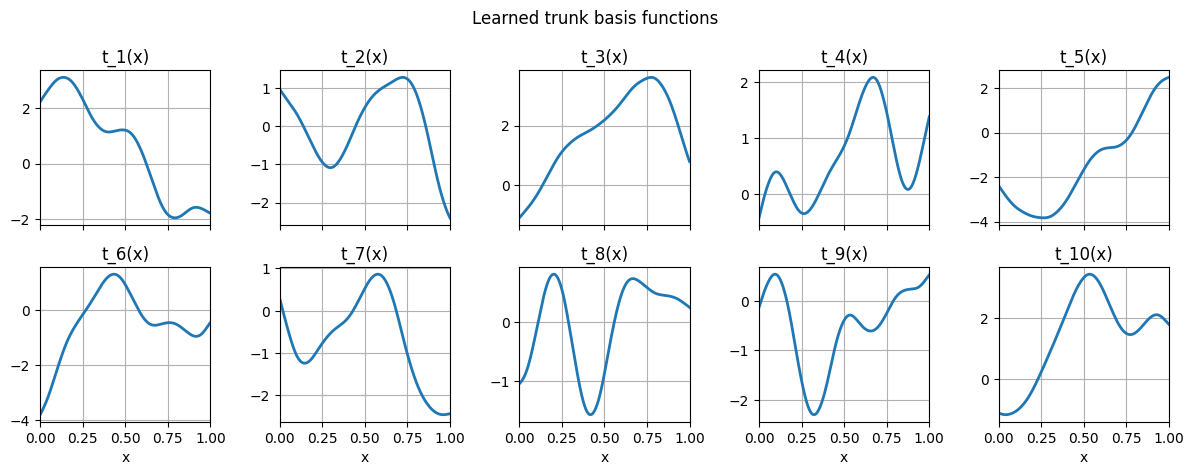

In [21]:
# Plot trunk outputs t_i(x) for i=1..p
model.eval()
with torch.no_grad():
    xg = torch.tensor(x_grid.reshape(-1, 1), dtype=torch.float32).to(device)
    T = model.trunk(xg).cpu().numpy()   # (n_grid, p)

fig, axes = plt.subplots(2, 5, figsize=(12, 4.8), sharex=True, sharey=False)
axes = axes.reshape(-1)
for i in range(p_latent):
    axes[i].plot(x_grid, T[:, i], lw=2)
    axes[i].set_title(f"t_{i+1}(x)")
    axes[i].set_xlim(0, 1)
for ax in axes[5:]:
    ax.set_xlabel("x")
plt.suptitle("Learned trunk basis functions")
plt.tight_layout()

### Interpreting the branch coefficients $b_i(u)$

Remember: the DeepONet prediction is
$$\hat v(x) = \sum_{i=1}^{p} b_i(u)\, t_i(x) + \text{bias}.$$

How to read the heatmap below depends on the **training distribution**:

- If a test input function looks similar to what you trained on, then $b(u)\in\mathbb{R}^p$ behaves like meaningful **coordinates** of $u$ in the learned latent basis.
- If a test input function is far from the training family, then $b(u)$ is best viewed as a **projection into the nearest representation the model knows**. In that case, a structured-looking row in the heatmap does **not** imply an accurate output prediction.

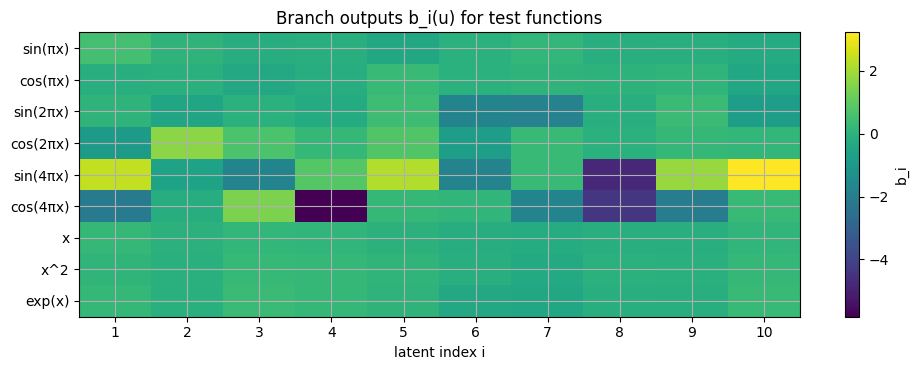

In [22]:
# Optional: visualize the branch coefficients b_i for each test input function
def branch_coeffs(u_func):
    u_s = u_func(x_sensors).astype(np.float32)
    Xb = torch.tensor(u_s.reshape(1, -1), dtype=torch.float32).to(device)
    with torch.no_grad():
        b = model.branch(Xb).cpu().numpy().reshape(-1)
    return b

names = [name for (name, _, _) in tests]
B = np.stack([branch_coeffs(u_func) for (_, u_func, _) in tests], axis=0)  # (n_tests, p)

fig, ax = plt.subplots(figsize=(10, 3.8))
im = ax.imshow(B, aspect="auto", cmap="viridis")
ax.set_yticks(range(len(names)))
ax.set_yticklabels(names)
ax.set_xticks(range(p_latent))
ax.set_xticklabels([str(i+1) for i in range(p_latent)])
ax.set_xlabel("latent index i")
ax.set_title("Branch outputs b_i(u) for test functions")
plt.colorbar(im, ax=ax, label="b_i")
plt.tight_layout()